Data path: ./MIMIC-CXR-png
Image root: ./MIMIC-CXR-png/MIMIC-CXR
Zip file already downloaded.
Images directory already exists (skipping unzip).
Image setup complete.
Using device: cuda
Training images: 549
Test images: 122
DataLoaders created successfully with Augmentation on Train set.
Train batches: 18
Test batches: 4
Loading one batch to verify...
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
Example labels: [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


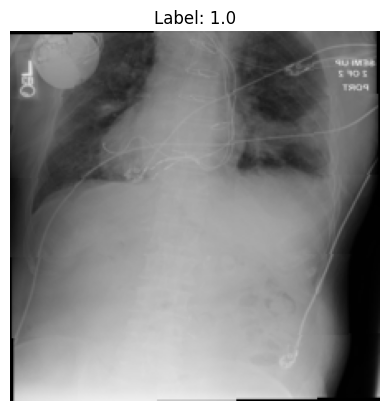

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

DATA_PATH = "./MIMIC-CXR-png"
IMG_ROOT = "./MIMIC-CXR-png/MIMIC-CXR"
IMAGE_SIZE = 224
BATCH_SIZE = 32
TARGET_INDEX = 9

print(f"Data path: {DATA_PATH}")
print(f"Image root: {IMG_ROOT}")

if not os.path.exists(DATA_PATH):
    print("Creating data path...")
    os.system(f"mkdir -p {DATA_PATH}")

if not os.path.exists(f"{DATA_PATH}/MIMIC-CXR.zip"):
    print("Downloading image zip file... This may take a while.")
    os.system(f"wget https://uni-bonn.sciebo.de/s/YHuwFOg6q6sw1ZX/download --output-document {DATA_PATH}/MIMIC-CXR.zip")
else:
    print("Zip file already downloaded.")

if not os.path.exists(IMG_ROOT):
    print(f"Unzipping images (this may take a minute)...")
    os.system(f"unzip -q {DATA_PATH}/MIMIC-CXR.zip -d {DATA_PATH}")
else:
    print("Images directory already exists (skipping unzip).")

print("Image setup complete.")

os.system(f"ls -l {IMG_ROOT}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

try:
    train_df = pd.read_csv("train_labels.csv")
    test_df = pd.read_csv("test_labels.csv")

    print(f"Training images: {len(train_df)}")
    print(f"Test images: {len(test_df)}")
except FileNotFoundError:
    print("Error: train_labels.csv or test_labels.csv not found.")
    print("Please upload these files to your Colab environment.")

!pip install pydicom

import pydicom

def parse_label_array(s: str) -> np.ndarray:
    s = str(s).strip().replace('[', '').replace(']', '').replace(',', ' ')
    return np.array([int(x) for x in s.split() if x.strip().isdigit()], dtype=int)

DICOM_ROOT = IMG_ROOT
def build_path_dcm(r):
    return f"{DICOM_ROOT}/files/p{str(r.subject_id)[:2]}/p{r.subject_id}/s{r.study_id}/{r.dicom_id}.dcm"

class CXRDicomDataset(Dataset):
    def __init__(self, df, transform, target_index=TARGET_INDEX):
        self.df = df
        self.transform = transform
        self.target_index = target_index
        self.df['image_path'] = self.df.apply(build_path_dcm, axis=1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        image_path = r['image_path']

        try:
            ds = pydicom.dcmread(image_path)
            arr = ds.pixel_array.astype(float)

            if arr.max() > 0:
                arr = (arr - arr.min()) / (arr.max() - arr.min())

            if ds.PhotometricInterpretation == "MONOCHROME1":
                arr = 1.0 - arr

            image = Image.fromarray((arr * 255).astype(np.uint8)).convert("RGB")

        except Exception as e:
            image = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE))

        image = self.transform(image)

        labels_vec = parse_label_array(r['labels_encoded'])
        label = torch.tensor(labels_vec[self.target_index], dtype=torch.float32)

        return image, label

data_transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_transform_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

if 'train_df' in locals() and 'test_df' in locals():
    train_dataset = CXRDicomDataset(train_df, data_transform_train)
    test_dataset = CXRDicomDataset(test_df, data_transform_test)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    print(f"DataLoaders created successfully with Augmentation on Train set.")
    print(f"Train batches: {len(train_loader)}")
    print(f"Test batches: {len(test_loader)}")
else:
    print("DataFrames not loaded. Skipping DataLoader creation.")

if 'train_loader' in locals():
    print("Loading one batch to verify...")
    try:
        images, labels = next(iter(train_loader))

        print(f"Image batch shape: {images.shape}")
        print(f"Label batch shape: {labels.shape}")
        print(f"Example labels: {labels[:8].tolist()}")

        plt.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)
        plt.title(f"Label: {labels[0].item()}")
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"Error loading batch: {e}")
        print("Please check your file paths and CSVs.")
else:
    print("train_loader not defined. Skipping sanity check.")

In [2]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, average_precision_score, confusion_matrix
import torch.optim as optim
import torch.nn as nn

print("Installing required libraries (peft and transformers)...")
!pip install -q peft transformers

from transformers import CLIPVisionModel
from peft import LoraConfig, get_peft_model

print("Loading MedCLIP model and processor...")

vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16")

for param in vision_model.parameters():
    param.requires_grad = False

vision_model = vision_model.to(DEVICE)
vision_model.eval()

print("Applying LoRA config...")
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
)

vision_model_lora = get_peft_model(vision_model, lora_config)
vision_model_lora.print_trainable_parameters()

class ClassificationHead(nn.Module):
    def __init__(self, input_dim=768, output_dim=1):
        super(ClassificationHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

classification_head = ClassificationHead().to(DEVICE)

optimizer = optim.Adam(
    list(vision_model_lora.parameters()) + list(classification_head.parameters()),
    lr=1e-4
)
criterion = nn.BCEWithLogitsLoss()

NUM_EPOCHS = 5
print(f"Starting training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    vision_model_lora.train()
    classification_head.train()

    train_loss = 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=True)

    for images, labels in train_loop:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()


        vision_outputs = vision_model_lora(pixel_values=images)


        image_features = vision_outputs['last_hidden_state'][:, 0, :]

        logits = classification_head(image_features)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Train Loss: {train_loss / len(train_loader):.4f}")

print("Training complete. Starting evaluation...")

vision_model_lora.eval()
classification_head.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(DEVICE)

        vision_outputs = vision_model_lora(pixel_values=images)

        image_features = vision_outputs['last_hidden_state'][:, 0, :]

        logits = classification_head(image_features)
        preds = torch.sigmoid(logits).cpu().numpy()

        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy().flatten())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_preds_binary = (all_preds > 0.5).astype(int)

auc = roc_auc_score(all_labels, all_preds)
auprc = average_precision_score(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds_binary)
f1 = f1_score(all_labels, all_preds_binary)
precision = precision_score(all_labels, all_preds_binary)
recall = recall_score(all_labels, all_preds_binary)

print("\n--- MedCLIP+LoRA Performance ---")
print(f"AUC: {auc:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

cm = confusion_matrix(all_labels, all_preds_binary)
print("\nConfusion Matrix:")
print(cm)

os.makedirs("artifacts/weights", exist_ok=True)
os.makedirs("artifacts/metrics", exist_ok=True)

model_save_path = "artifacts/weights/medclip_lora_final.pth"
torch.save({
    'vision_model_lora': vision_model_lora.state_dict(),
    'classification_head': classification_head.state_dict(),
}, model_save_path)
print(f"Model weights saved to {model_save_path}")

metrics_df = pd.DataFrame({
    'Model': ['MedCLIP+LoRA (Vision)'],
    'AUC': [auc],
    'AUPRC': [auprc],
    'Accuracy': [acc],
    'F1': [f1],
    'Precision': [precision],
    'Recall': [recall]
})
metrics_save_path = "artifacts/metrics/medclip_lora_results.csv"
metrics_df.to_csv(metrics_save_path, index=False)
print(f"Metrics saved to {metrics_save_path}")

print("\nStep 2 Complete.")

Installing required libraries (peft and transformers)...
Loading MedCLIP model and processor...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Applying LoRA config...
trainable params: 589,824 || all params: 86,389,248 || trainable%: 0.6828
Starting training for 5 epochs...


Epoch 1/5: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it, loss=0.684]


Epoch 1 Train Loss: 0.6866


Epoch 2/5: 100%|██████████| 18/18 [00:40<00:00,  2.27s/it, loss=0.66]


Epoch 2 Train Loss: 0.6641


Epoch 3/5: 100%|██████████| 18/18 [00:40<00:00,  2.26s/it, loss=0.847]


Epoch 3 Train Loss: 0.6479


Epoch 4/5: 100%|██████████| 18/18 [00:40<00:00,  2.25s/it, loss=0.697]


Epoch 4 Train Loss: 0.6106


Epoch 5/5: 100%|██████████| 18/18 [00:40<00:00,  2.24s/it, loss=0.631]


Epoch 5 Train Loss: 0.5982
Training complete. Starting evaluation...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]



--- MedCLIP+LoRA Performance ---
AUC: 0.7222
AUPRC: 0.7535
Accuracy: 0.6885
F1-Score: 0.6200
Precision: 0.6739
Recall: 0.5741

Confusion Matrix:
[[53 15]
 [23 31]]
Model weights saved to artifacts/weights/medclip_lora_final.pth
Metrics saved to artifacts/metrics/medclip_lora_results.csv

Step 2 Complete.


In [3]:
print("Installing 'timm' library for EfficientNet...")
!pip install -q timm

import timm

print("Creating EfficientNet-B0 model...")

model_cnn = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
model_cnn = model_cnn.to(DEVICE)

optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-4)
criterion_cnn = nn.BCEWithLogitsLoss()

NUM_EPOCHS_CNN = 5
print(f"Starting CNN training for {NUM_EPOCHS_CNN} epochs...")

for epoch in range(NUM_EPOCHS_CNN):
    model_cnn.train()
    train_loss = 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_CNN}", leave=True)

    for images, labels in train_loop:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).unsqueeze(1)

        optimizer_cnn.zero_grad()

        logits = model_cnn(images)
        loss = criterion_cnn(logits, labels)

        loss.backward()
        optimizer_cnn.step()

        train_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} CNN Train Loss: {train_loss / len(train_loader):.4f}")

print("CNN Training complete. Starting evaluation...")

model_cnn.eval()
all_labels_cnn = []
all_preds_cnn = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating CNN"):
        images = images.to(DEVICE)

        logits = model_cnn(images)
        preds = torch.sigmoid(logits).cpu().numpy()

        all_preds_cnn.extend(preds.flatten())
        all_labels_cnn.extend(labels.numpy().flatten())

all_labels_cnn = np.array(all_labels_cnn)
all_preds_cnn = np.array(all_preds_cnn)
all_preds_binary_cnn = (all_preds_cnn > 0.5).astype(int)

auc_cnn = roc_auc_score(all_labels_cnn, all_preds_cnn)
auprc_cnn = average_precision_score(all_labels_cnn, all_preds_cnn)
acc_cnn = accuracy_score(all_labels_cnn, all_preds_binary_cnn)
f1_cnn = f1_score(all_labels_cnn, all_preds_binary_cnn)
precision_cnn = precision_score(all_labels_cnn, all_preds_binary_cnn)
recall_cnn = recall_score(all_labels_cnn, all_preds_binary_cnn)

print("\n--- CNN (EfficientNet-B0) Performance ---")
print(f"AUC: {auc_cnn:.4f}")
print(f"AUPRC: {auprc_cnn:.4f}")
print(f"Accuracy: {acc_cnn:.4f}")
print(f"F1-Score: {f1_cnn:.4f}")
print(f"Precision: {precision_cnn:.4f}")
print(f"Recall: {recall_cnn:.4f}")

cm_cnn = confusion_matrix(all_labels_cnn, all_preds_binary_cnn)
print("\nConfusion Matrix:")
print(cm_cnn)

model_cnn_save_path = "artifacts/weights/cnn_effnet_final.pth"
torch.save(model_cnn.state_dict(), model_cnn_save_path)
print(f"CNN model weights saved to {model_cnn_save_path}")

metrics_cnn_df = pd.DataFrame({
    'Model': ['CNN (EfficientNet-B0)'],
    'AUC': [auc_cnn],
    'AUPRC': [auprc_cnn],
    'Accuracy': [acc_cnn],
    'F1': [f1_cnn],
    'Precision': [precision_cnn],
    'Recall': [recall_cnn]
})
metrics_cnn_save_path = "artifacts/metrics/cnn_effnet_results.csv"
metrics_cnn_df.to_csv(metrics_cnn_save_path, index=False)
print(f"CNN metrics saved to {metrics_cnn_save_path}")

print("\nStep 3 Complete.")

Installing 'timm' library for EfficientNet...
Creating EfficientNet-B0 model...
Starting CNN training for 5 epochs...


Epoch 1/5: 100%|██████████| 18/18 [00:43<00:00,  2.39s/it, loss=1.05]


Epoch 1 CNN Train Loss: 1.6131


Epoch 2/5: 100%|██████████| 18/18 [00:40<00:00,  2.27s/it, loss=0.332]


Epoch 2 CNN Train Loss: 0.8026


Epoch 3/5: 100%|██████████| 18/18 [00:41<00:00,  2.30s/it, loss=2.61]


Epoch 3 CNN Train Loss: 0.8448


Epoch 4/5: 100%|██████████| 18/18 [00:40<00:00,  2.27s/it, loss=0.514]


Epoch 4 CNN Train Loss: 0.5280


Epoch 5/5: 100%|██████████| 18/18 [00:39<00:00,  2.22s/it, loss=0.118]


Epoch 5 CNN Train Loss: 0.3997
CNN Training complete. Starting evaluation...


Evaluating CNN: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]



--- CNN (EfficientNet-B0) Performance ---
AUC: 0.7105
AUPRC: 0.6980
Accuracy: 0.6311
F1-Score: 0.6218
Precision: 0.5692
Recall: 0.6852

Confusion Matrix:
[[40 28]
 [17 37]]
CNN model weights saved to artifacts/weights/cnn_effnet_final.pth
CNN metrics saved to artifacts/metrics/cnn_effnet_results.csv

Step 3 Complete.


Starting Step 4: Explainability (Grad-CAM)...
Installing 'grad-cam' library (if not already installed)...
Setting up Grad-CAM...
Generating Grad-CAM visualizations...
Grad-CAM grid saved to artifacts/figures/grad_cam_grid.png


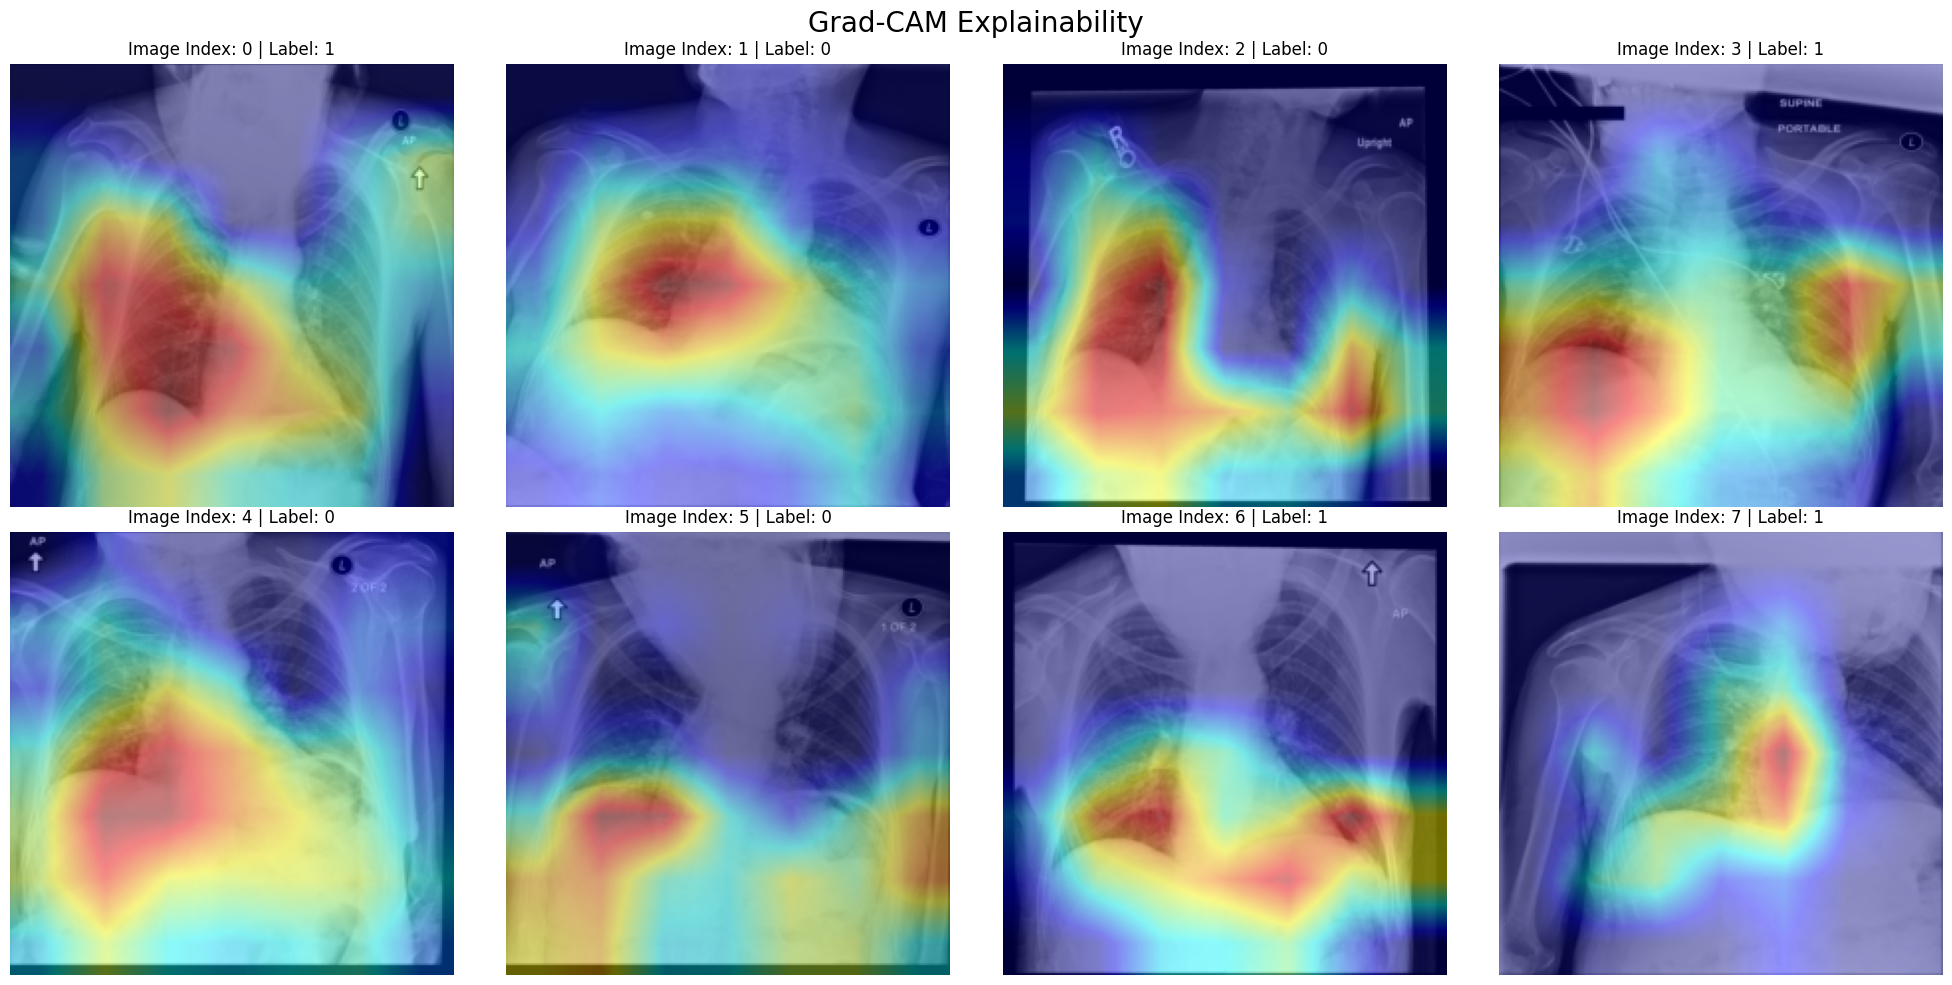


Step 4 Complete.


In [4]:
import os
import matplotlib.pyplot as plt

print("Starting Step 4: Explainability (Grad-CAM)...")

print("Installing 'grad-cam' library (if not already installed)...")
!pip install -q grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

print("Setting up Grad-CAM...")

target_layers = [model_cnn.conv_head]

cam = GradCAM(model=model_cnn, target_layers=target_layers)

print("Generating Grad-CAM visualizations...")

images, labels = next(iter(test_loader))

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Grad-CAM Explainability", fontsize=20)

for i in range(8):
    if i >= len(images):
        break

    input_tensor = images[i].unsqueeze(0).to(DEVICE)

    grayscale_cam = cam(input_tensor=input_tensor, targets=None)

    grayscale_cam = grayscale_cam[0, :]

    unnormalized_image = images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5

    visualization = show_cam_on_image(unnormalized_image, grayscale_cam, use_rgb=True, image_weight=0.6)

    ax = axs[i//4, i%4]
    ax.imshow(visualization)
    ax.set_title(f"Image Index: {i} | Label: {labels[i].item():.0f}")
    ax.axis('off')

plt.tight_layout()

os.makedirs("artifacts/figures", exist_ok=True)
figure_save_path = "artifacts/figures/grad_cam_grid.png"
plt.savefig(figure_save_path)

print(f"Grad-CAM grid saved to {figure_save_path}")
plt.show()

print("\nStep 4 Complete.")

In [5]:
print("Starting Step 5: Fairness Analysis")

get_ipython().system('pip install -q fairlearn')

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate
from sklearn.metrics import recall_score, precision_score
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Loading metadata for sensitive features...")

metadata_df = pd.read_csv("/content/metadata_clean.csv")

print("Re-running evaluation on test_loader to get all predictions...")

model_cnn.eval()
all_labels = []
all_preds_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_cnn(images)
        probs = torch.sigmoid(outputs).squeeze()

        all_labels.extend(labels.cpu().numpy())
        all_preds_probs.extend(probs.cpu().numpy())

all_preds = (np.array(all_preds_probs) >= 0.5).astype(int)
all_labels = np.array(all_labels).astype(int)

print("Merging predictions with sensitive features (ViewCodeSequence_CodeMeaning)...")

test_df_with_preds = test_df.copy()
if len(test_df_with_preds) != len(all_labels):
    print(f"Warning: Length mismatch. test_df has {len(test_df_with_preds)} rows, but test_loader produced {len(all_labels)} predictions.")
    test_df_with_preds = test_df_with_preds.iloc[:len(all_labels)]

test_df_with_preds['true_label'] = all_labels
test_df_with_preds['prediction'] = all_preds

merged_for_fairness = test_df_with_preds.merge(
    metadata_df[['subject_id', 'study_id', 'dicom_id', 'ViewCodeSequence_CodeMeaning']],
    on=['subject_id', 'study_id', 'dicom_id'],
    how='left'
)

merged_for_fairness.dropna(subset=['ViewCodeSequence_CodeMeaning'], inplace=True)

if merged_for_fairness.empty:
    print("ERROR: No matching data found after merging with metadata.")
    print("Please check that 'subject_id', 'study_id', and 'dicom_id' columns match.")
else:
    print("Calculating fairness metrics...")

    y_true = merged_for_fairness['true_label']
    y_pred = merged_for_fairness['prediction']
    sensitive_features = merged_for_fairness['ViewCodeSequence_CodeMeaning']

    metrics = {
        'accuracy': lambda y_t, y_p: (y_t == y_p).mean(),
        'precision': precision_score,
        'recall (sensitivity)': recall_score,
        'selection_rate': selection_rate,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate
    }

    metric_frame = MetricFrame(
        metrics=metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )

    print("\n--- Fairness Analysis Results (by View) ---")
    print(metric_frame.by_group)

    print("\n--- Fairness Disparities (Difference) ---")
    print(metric_frame.difference(method='between_groups'))

print("\nStep 5 Complete.")

Starting Step 5: Fairness Analysis
Loading metadata for sensitive features...
Re-running evaluation on test_loader to get all predictions...
Merging predictions with sensitive features (ViewCodeSequence_CodeMeaning)...
Calculating fairness metrics...

--- Fairness Analysis Results (by View) ---
                              accuracy  precision  recall (sensitivity)  \
ViewCodeSequence_CodeMeaning                                              
antero-posterior              0.569767   0.466667              0.617647   
postero-anterior              0.777778   0.800000              0.800000   

                              selection_rate  false_positive_rate  \
ViewCodeSequence_CodeMeaning                                        
antero-posterior                    0.523256             0.461538   
postero-anterior                    0.555556             0.250000   

                              false_negative_rate  
ViewCodeSequence_CodeMeaning                       
antero-posterior      

In [6]:
print("Loading radiomics features...")
try:
    features_df = pd.read_csv("features_raw.csv")
    print(f"Radiomics features loaded: {len(features_df)} samples.")
    display(features_df.head())
except FileNotFoundError:
    print("Error: features_raw.csv not found.")
    print("Please ensure 'features_raw.csv' is uploaded to your Colab environment.")
    features_df = None
print("Starting Step 6: Training ML Models via 5-Fold Cross-Validation...")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, precision_score, recall_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

print("Loading and preparing full radiomics dataset for CV...")

merge_cols = ['subject_id', 'study_id']
feature_cols = [col for col in features_df.columns if col not in merge_cols and col != 'dicom_path']

full_data_ml = pd.concat([train_df, test_df], ignore_index=True)
full_data_ml = full_data_ml.merge(features_df[merge_cols + feature_cols], on=merge_cols, how='inner')

full_data_ml.dropna(subset=feature_cols, inplace=True)

X_full_ml = full_data_ml[feature_cols].reset_index(drop=True)
Y_full_ml = full_data_ml['labels_encoded'].apply(lambda x: parse_label_array(x)[TARGET_INDEX]).reset_index(drop=True)
print(f"Full ML dataset size (images with radiomics): {len(X_full_ml)} samples.")
print(f"Feature set size: {len(feature_cols)} features.")


models_to_run = {
    'ML (LogisticRegression)': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'ML (RandomForest)': RandomForestClassifier(class_weight='balanced', random_state=42),
    'ML (KNN)': KNeighborsClassifier(n_neighbors=5)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ml_metrics_cv = []
ml_probs_cv_dict = {name: [] for name in models_to_run.keys()}

for model_name, model in models_to_run.items():

    auc_folds, auprc_folds, acc_folds, f1_folds, prec_folds, recall_folds = [], [], [], [], [], []
    y_test_cv_all, y_prob_cv_all = [], []

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_full_ml, Y_full_ml)):
        X_train_fold, X_test_fold = X_full_ml.iloc[train_idx], X_full_ml.iloc[test_idx]
        Y_train_fold, Y_test_fold = Y_full_ml.iloc[train_idx], Y_full_ml.iloc[test_idx]

        pipeline = ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('model', model)
        ])

        pipeline.fit(X_train_fold, Y_train_fold)

        y_probs = pipeline.predict_proba(X_test_fold)[:, 1]
        y_preds = (y_probs >= 0.5).astype(int)

        auc_folds.append(roc_auc_score(Y_test_fold, y_probs))
        auprc_folds.append(average_precision_score(Y_test_fold, y_probs))
        acc_folds.append(accuracy_score(Y_test_fold, y_preds))
        f1_folds.append(f1_score(Y_test_fold, y_preds, zero_division=0))
        prec_folds.append(precision_score(Y_test_fold, y_preds, zero_division=0))
        recall_folds.append(recall_score(Y_test_fold, y_preds, zero_division=0))

        y_test_cv_all.extend(Y_test_fold.tolist())
        y_prob_cv_all.extend(y_probs.tolist())

    print(f"\n--- CV Results: {model_name} (Average of 5 Folds) ---")
    print(f"Avg. AUC: {np.mean(auc_folds):.4f} (Std: {np.std(auc_folds):.4f})")
    print(f"Avg. AUPRC: {np.mean(auprc_folds):.4f}")
    print(f"Avg. F1: {np.mean(f1_folds):.4f}")

    ml_metrics_cv.append({
        'Model': model_name,
        'AUC': np.mean(auc_folds),
        'AUPRC': np.mean(auprc_folds),
        'Accuracy': np.mean(acc_folds),
        'F1-Score': np.mean(f1_folds),
        'Precision': np.mean(prec_folds),
        'Recall': np.mean(recall_folds)
    })

    ml_probs_cv_dict[model_name] = {'y_true': np.array(y_test_cv_all), 'y_prob': np.array(y_prob_cv_all)}

print("\nSaving final CV aggregated ML metrics...")
ml_metrics_df = pd.DataFrame(ml_metrics_cv)
ml_metrics_df.to_csv("artifacts/metrics/ml_all_results_CV.csv", index=False)

all_ml_probs = pd.DataFrame({
    'y_true': ml_probs_cv_dict['ML (LogisticRegression)']['y_true'],
    'y_prob_LR': ml_probs_cv_dict['ML (LogisticRegression)']['y_prob'],
    'y_prob_RF': ml_probs_cv_dict['ML (RandomForest)']['y_prob'],
    'y_prob_KNN': ml_probs_cv_dict['ML (KNN)']['y_prob']
})
all_ml_probs.to_csv("artifacts/metrics/ml_all_probs_CV.csv", index=False)

print("ML metrics and probabilities saved using Cross-Validation.")
print("\nStep 6 Complete.")

Loading radiomics features...
Radiomics features loaded: 45 samples.


,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject_id,study_id,dicom_path
0,-1.278524,0.855135,3.209739e+06,0.847227,1.163292,2.215956,1.373047,0.651548,-0.435326,-0.660705,...,0.000858,1.448904e+09,50366.395143,0.000056,0.008836,0.001758,0.000056,18000291,55388853,files/p18/p18000291/s55388853/04564240-d4e9e69...
1,-1.313175,0.854954,3.300384e+06,0.839250,1.167722,2.261075,1.385948,0.657629,-0.451919,-0.669476,...,0.000842,1.485832e+09,42652.852381,0.000060,0.008285,0.001627,0.000060,18000291,55388853,files/p18/p18000291/s55388853/ed82a88d-499bed8...
2,-1.128694,0.825043,9.963108e+05,0.868463,1.128072,2.452143,1.815657,0.622337,-0.358779,-0.610935,...,0.001176,3.804332e+08,30442.847749,0.000126,0.010801,0.002224,0.000126,18000379,51062789,files/p18/p18000379/s51062789/eac2b8fa-9245fe4...
3,-1.029863,1.083006,1.473029e+06,0.993817,1.266049,1.926242,1.567053,0.647344,-0.021913,-0.097315,...,0.001282,5.780411e+08,26498.936541,0.000052,0.015052,0.003731,0.000052,18000379,51568340,files/p18/p18000379/s51568340/3631ff3b-cfcb244...
4,-0.821600,1.128441,1.440104e+06,0.999173,1.235120,1.865436,1.651462,0.626043,0.091044,0.045712,...,0.001797,4.620669e+08,22498.454022,0.000040,0.018150,0.004532,0.000040,18000379,51817182,files/p18/p18000379/s51817182/f6f04111-c3fde25...


Starting Step 6: Training ML Models via 5-Fold Cross-Validation...
Loading and preparing full radiomics dataset for CV...
Full ML dataset size (images with radiomics): 57 samples.
Feature set size: 93 features.

--- CV Results: ML (LogisticRegression) (Average of 5 Folds) ---
Avg. AUC: 0.7444 (Std: 0.1510)
Avg. AUPRC: 0.7757
Avg. F1: 0.7200

--- CV Results: ML (RandomForest) (Average of 5 Folds) ---
Avg. AUC: 0.8044 (Std: 0.1161)
Avg. AUPRC: 0.7969
Avg. F1: 0.6622

--- CV Results: ML (KNN) (Average of 5 Folds) ---
Avg. AUC: 0.6294 (Std: 0.2370)
Avg. AUPRC: 0.6752
Avg. F1: 0.5923

Saving final CV aggregated ML metrics...
ML metrics and probabilities saved using Cross-Validation.

Step 6 Complete.


In [7]:
print("Step 7A: FORCING MEDCLIP WEIGHTS TO RE-SAVE with correct keys...")

new_model_path = "artifacts/weights/medclip_lora_FIXED.pth"

try:
    torch.save({
        'vision_model_state': vision_model_lora.state_dict(),
        'head_state': classification_head.state_dict(),
    }, new_model_path)

    print(f"Successfully saved corrected weights to: {new_model_path}")

except NameError as e:
    print(f"CRITICAL ERROR: MedCLIP model objects are not in memory ('vision_model_lora' or 'classification_head').")
    print(f"You MUST re-run Step 2 (MedCLIP training) to load the models into memory.")
    raise e

except Exception as e:
    print(f"An unexpected error occurred during saving: {e}")

print("\nStep 7A Complete.")

Step 7A: FORCING MEDCLIP WEIGHTS TO RE-SAVE with correct keys...
Successfully saved corrected weights to: artifacts/weights/medclip_lora_FIXED.pth

Step 7A Complete.


Starting Step 7B: Generating Final Tables and Plots (ML+DL+FM)...

--- Final Model Comparison Table ---
                     Model       AUC     AUPRC  Accuracy        F1  Precision    Recall
0  ML (LogisticRegression)  0.744444  0.775660  0.737879  0.720000   0.731111  0.733333
1        ML (RandomForest)  0.804444  0.796929  0.703030  0.662222   0.669524  0.673333
2                 ML (KNN)  0.629444  0.675245  0.615152  0.592308   0.600000  0.626667
3    CNN (EfficientNet-B0)  0.710512  0.697964  0.631148  0.621849   0.569231  0.685185
4    MedCLIP+LoRA (Vision)  0.722222  0.753534  0.688525  0.620000   0.673913  0.574074
Final comparison table saved to artifacts/metrics/FINAL_Model_Comparison_Full.csv
Re-initializing MedCLIP model and head...


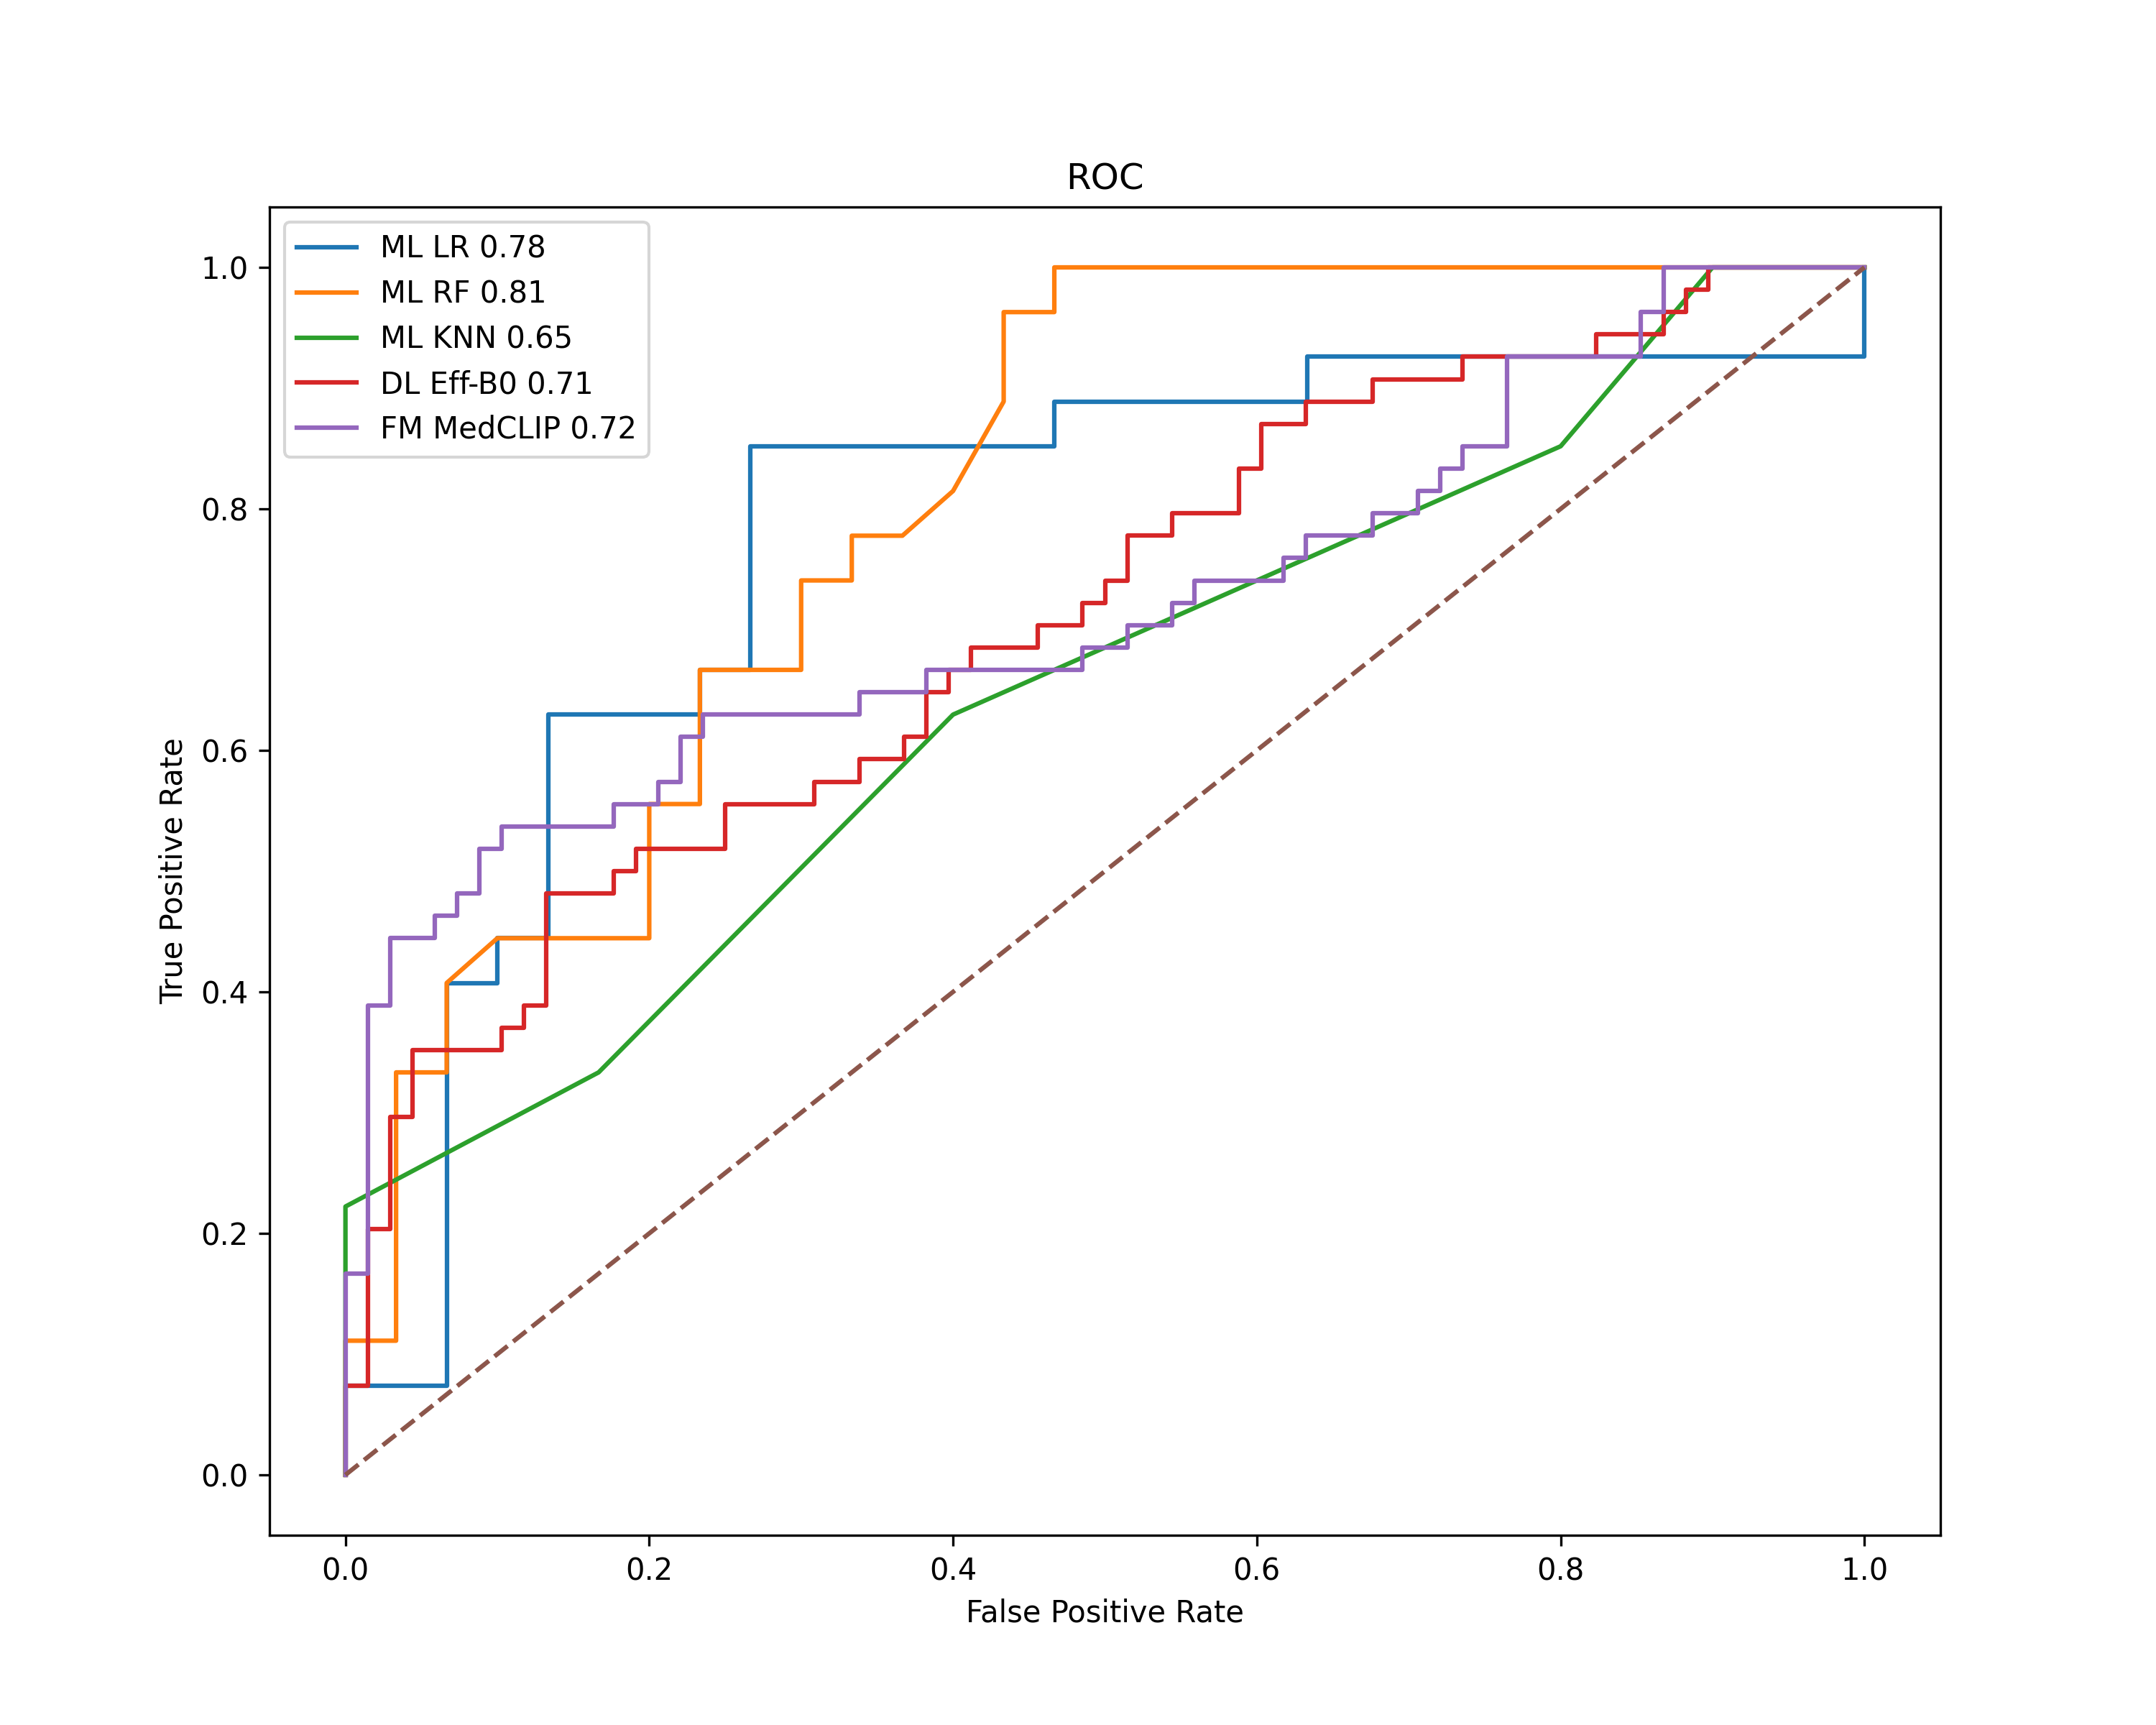

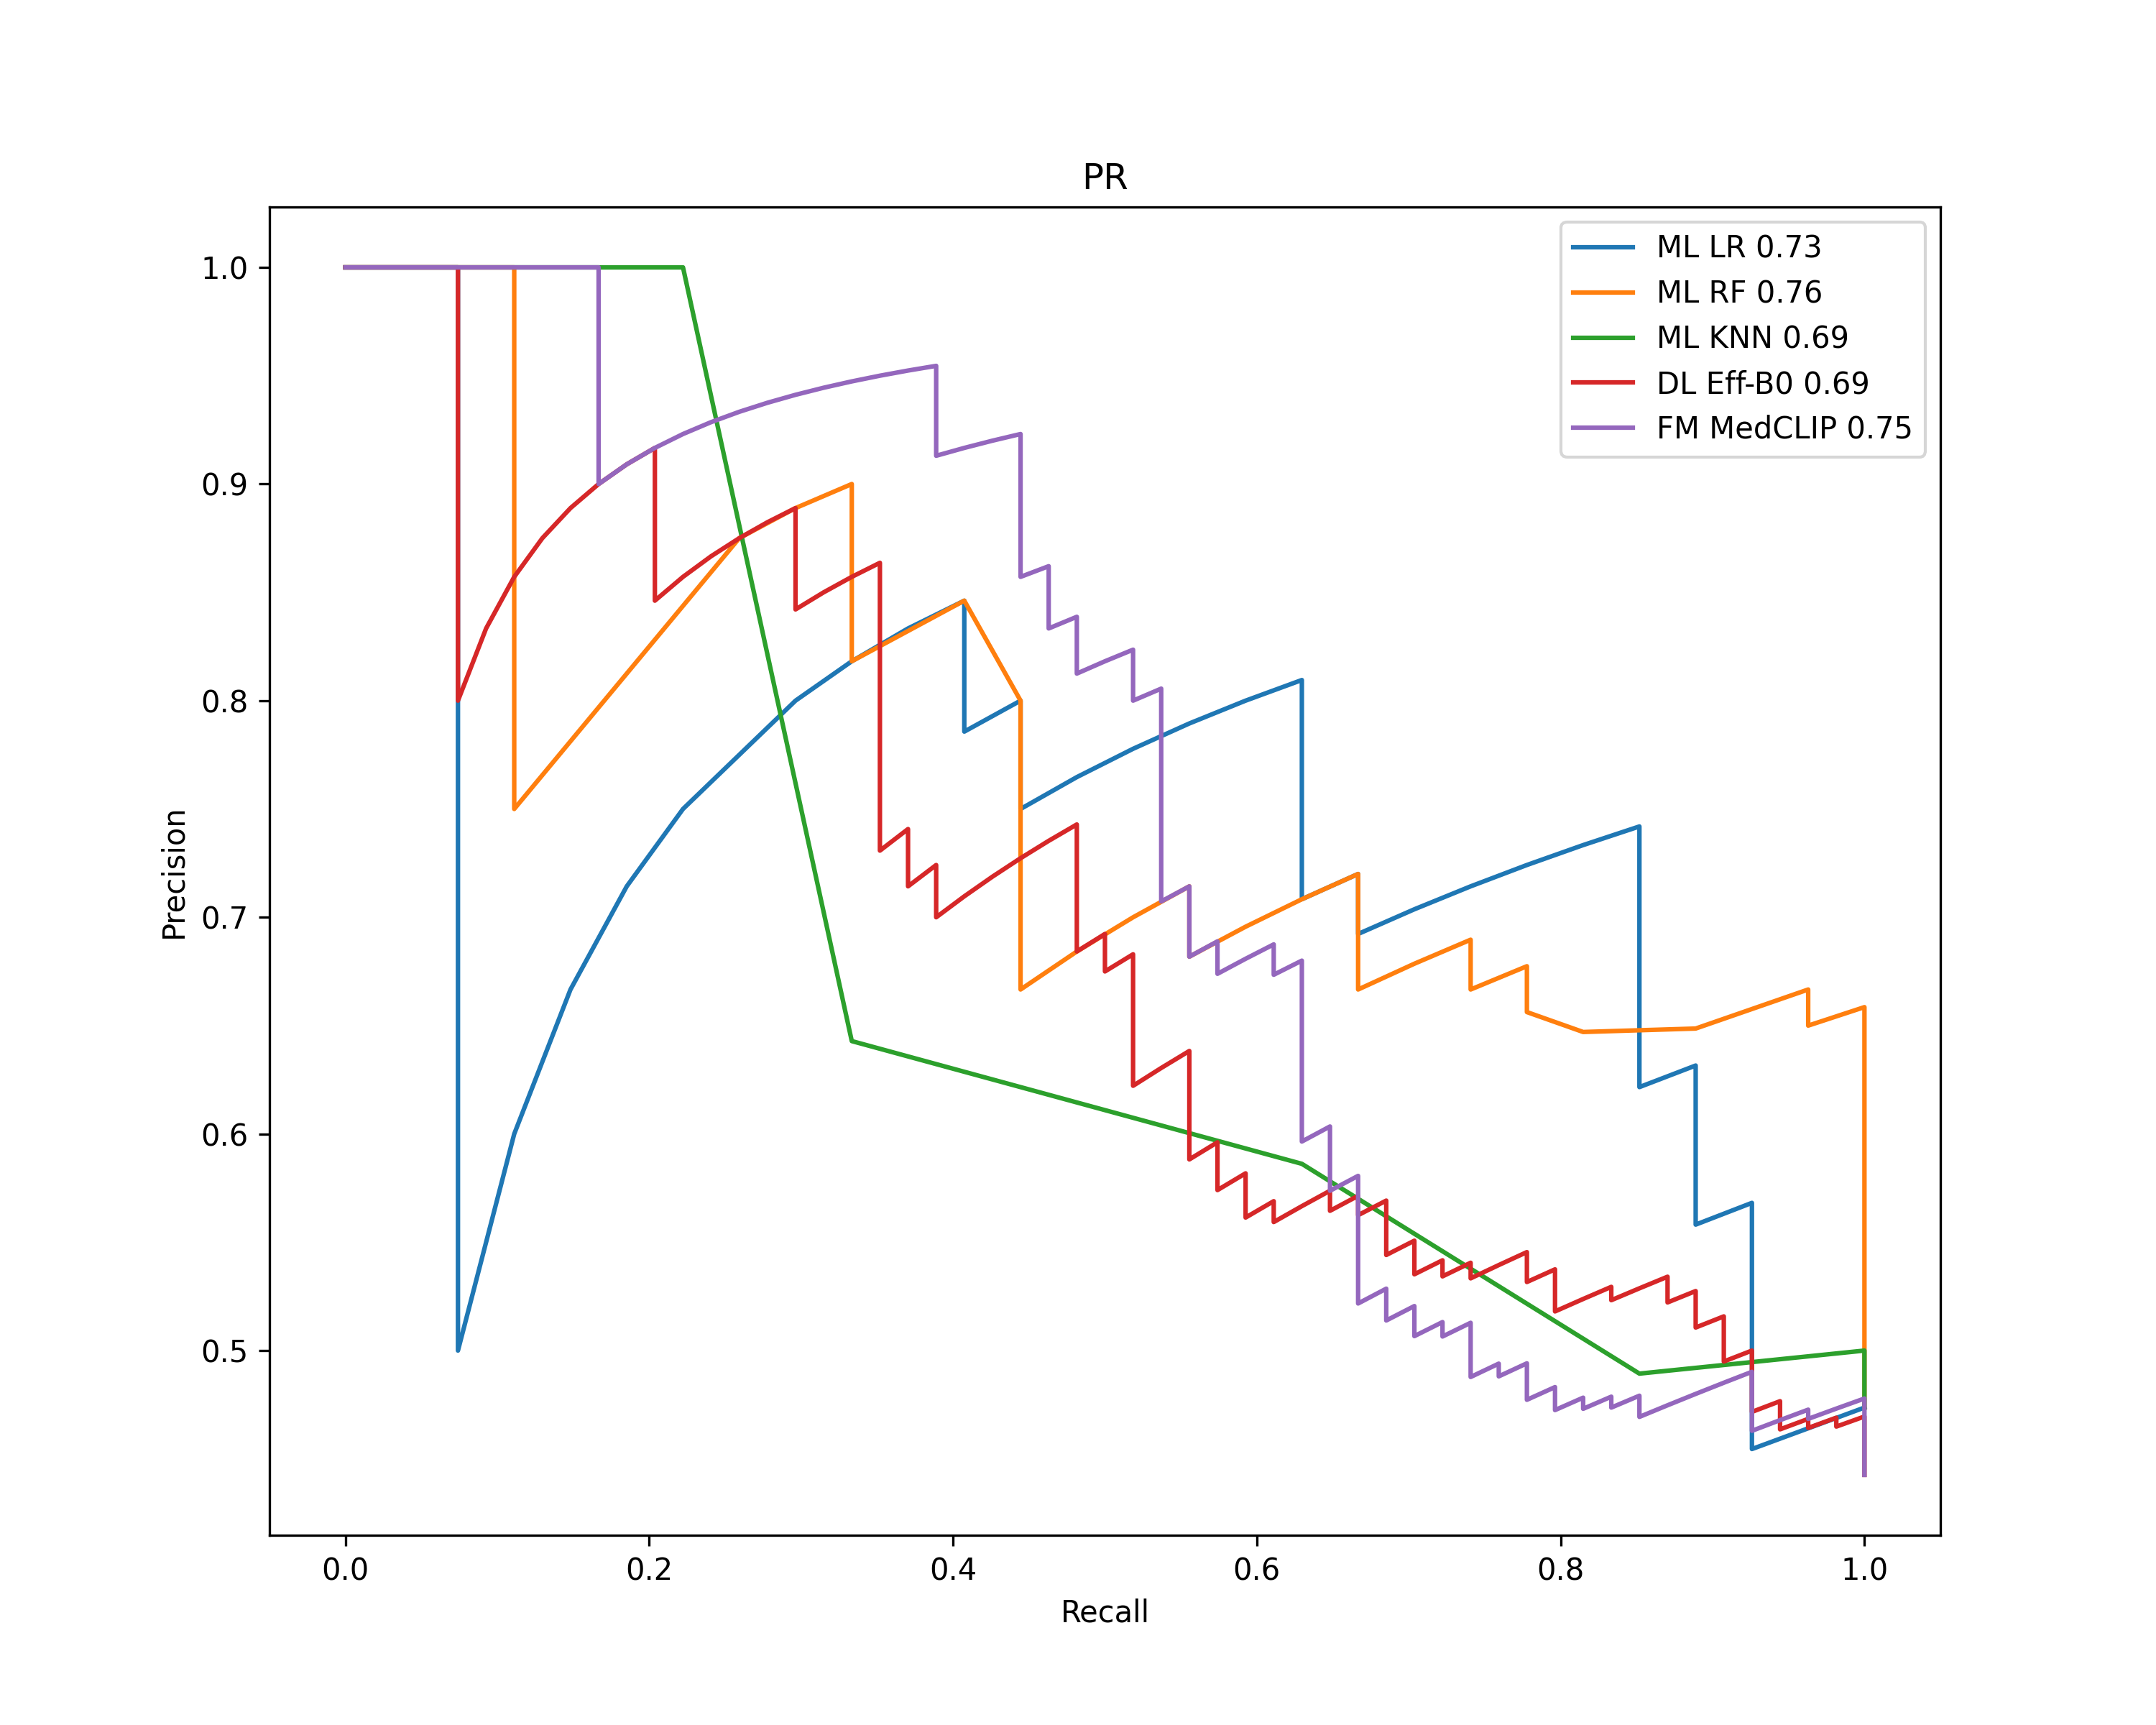


Step 7B Complete.


In [8]:
print("Starting Step 7B: Generating Final Tables and Plots (ML+DL+FM)...")

import os, sys, traceback, torch, torch.nn as nn, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from IPython.display import display, Image as IPyImage
from peft import LoraConfig, get_peft_model
from transformers import CLIPVisionConfig, CLIPVisionModel
from PIL import Image as PILImage
Image = PILImage
sys.modules['Image'] = PILImage

def infer_clip_config_from_ckpt(sd):
    k_patch = [k for k in sd.keys() if "embeddings.patch_embedding.weight" in k][0]
    w = sd[k_patch]; patch_size = int(w.shape[2])
    k_pos = [k for k in sd.keys() if "embeddings.position_embedding.weight" in k][0]
    pos_len = sd[k_pos].shape[0]
    return patch_size, pos_len

def require_vars(names):
    m = [n for n in names if n not in globals()]
    if m: raise RuntimeError(str(m))

os.makedirs("artifacts/figures", exist_ok=True)
os.makedirs("artifacts/metrics", exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ml_metrics_path = "artifacts/metrics/ml_all_results_CV.csv"
cnn_metrics_path = "artifacts/metrics/cnn_effnet_results.csv"
medclip_metrics_path = "artifacts/metrics/medclip_lora_results.csv"

if not os.path.exists(ml_metrics_path): raise FileNotFoundError(ml_metrics_path)
if not os.path.exists(cnn_metrics_path): raise FileNotFoundError(cnn_metrics_path)
if not os.path.exists(medclip_metrics_path): raise FileNotFoundError(medclip_metrics_path)

ml_metrics_df = pd.read_csv(ml_metrics_path)
cnn_metrics_df = pd.read_csv(cnn_metrics_path)
medclip_metrics_df = pd.read_csv(medclip_metrics_path)

ml_metrics_df = ml_metrics_df.rename(columns={'F1-Score': 'F1'})

final_metrics_df = pd.concat([ml_metrics_df, cnn_metrics_df, medclip_metrics_df], ignore_index=True)


final_metrics_df = final_metrics_df[['Model', 'AUC', 'AUPRC', 'Accuracy', 'F1', 'Precision', 'Recall']]

print("\n--- Final Model Comparison Table ---")
print(final_metrics_df.to_string())

final_table_path = "artifacts/metrics/FINAL_Model_Comparison_Full.csv"
final_metrics_df.to_csv(final_table_path, index=False)
print(f"Final comparison table saved to {final_table_path}")

ml_probs_path = "artifacts/metrics/ml_all_probs_CV.csv"
if not os.path.exists(ml_probs_path): raise FileNotFoundError(ml_probs_path)
ml_probs_df = pd.read_csv(ml_probs_path)
y_true_ml  = ml_probs_df["y_true"].to_numpy(float)
y_prob_lr  = ml_probs_df["y_prob_LR"].to_numpy(float)
y_prob_rf  = ml_probs_df["y_prob_RF"].to_numpy(float)
y_prob_knn = ml_probs_df["y_prob_KNN"].to_numpy(float)


model_cnn.to(DEVICE).eval()

weights_path = "artifacts/weights/medclip_lora_FIXED.pth"
if not os.path.exists(weights_path):
    original_weights_path = "artifacts/weights/medclip_lora_final.pth"
    if os.path.exists(original_weights_path):
        weights_path = original_weights_path
        print(f"Warning: Fixed weights not found, using original weights from {weights_path}")
    else:
        raise FileNotFoundError(f"Neither fixed nor original weights found: {weights_path}, {original_weights_path}")

ckpt = torch.load(weights_path, map_location=DEVICE)
vision_sd = ckpt.get("vision_model_state", ckpt.get("vision_model_lora", ckpt))
head_sd   = ckpt.get("head_state", ckpt.get("classification_head", None))

try:
    reinitialize_models = False
    if 'vision_model_lora' not in globals() or vision_model_lora.device != DEVICE or \
       'classification_head' not in globals() or classification_head.device != DEVICE:
        reinitialize_models = True
    if head_sd and all(k.startswith(('fc1', 'fc2')) for k in head_sd.keys()):
         reinitialize_models = True


    if reinitialize_models:
        print("Re-initializing MedCLIP model and head...")
        patch_size, pos_len = infer_clip_config_from_ckpt(vision_sd)
        vision_cfg = CLIPVisionConfig(hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072, image_size=224, patch_size=patch_size)
        vision_model = CLIPVisionModel(vision_cfg)
        for p in vision_model.parameters(): p.requires_grad = False
        lora_config = LoraConfig(r=16, lora_alpha=16, target_modules=["q_proj","v_proj"], lora_dropout=0.1, bias="none") # Used "q_proj", "v_proj" in Step 2
        vision_model_lora = get_peft_model(vision_model, lora_config)

        classification_head = nn.Sequential(
            nn.Linear(vision_model.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        ).to(DEVICE)


        vision_model_lora.load_state_dict(vision_sd, strict=False)
        if head_sd is not None:
            if any(k.startswith(('fc1', 'fc2')) for k in head_sd.keys()):
                corrected_head_sd = {}
                for k, v in head_sd.items():
                    if k.startswith('fc1'):
                        corrected_head_sd[k.replace('fc1', '0')] = v
                    elif k.startswith('fc2'):
                        corrected_head_sd[k.replace('fc2', '3')] = v
                classification_head.load_state_dict(corrected_head_sd, strict=True)
            else:
                classification_head.load_state_dict(head_sd, strict=True)

    vision_model_lora.to(DEVICE).eval()
    classification_head.to(DEVICE).eval()

except Exception as e:
    print(f"Error during MedCLIP model re-initialization or loading state dict: {e}")
    raise e


all_labels, probs_cnn, probs_med = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        logits_cnn = model_cnn(images)
        pc = torch.sigmoid(logits_cnn).flatten().cpu().numpy()
        feats = vision_model_lora(pixel_values=images).pooler_output
        logits_med = classification_head(feats)
        pm = torch.sigmoid(logits_med).flatten().cpu().numpy()
        all_labels.extend(labels.cpu().numpy().tolist())
        probs_cnn.extend(pc.tolist())
        probs_med.extend(pm.tolist())

y_true = np.asarray(all_labels,float)
y_prob_cnn = np.asarray(probs_cnn,float)
y_prob_medclip = np.asarray(probs_med,float)

np.save("artifacts/metrics/y_true_test.npy", y_true)
np.save("artifacts/metrics/y_prob_cnn.npy", y_prob_cnn)
np.save("artifacts/metrics/y_prob_medclip.npy", y_prob_medclip)

try:
    if 'y_true_ml' not in globals() or 'y_prob_lr' not in globals() or 'y_prob_rf' not in globals() or 'y_prob_knn' not in globals():
        print("Loading ML probabilities from CSV...")
        ml_probs_path = "artifacts/metrics/ml_all_probs_CV.csv"
        if not os.path.exists(ml_probs_path):
             raise FileNotFoundError(ml_probs_path)
        ml_probs_df = pd.read_csv(ml_probs_path)
        y_true_ml  = ml_probs_df["y_true"].to_numpy(float)
        y_prob_lr  = ml_probs_df["y_prob_LR"].to_numpy(float)
        y_prob_rf  = ml_probs_df["y_prob_RF"].to_numpy(float)
        y_prob_knn = ml_probs_df["y_prob_KNN"].to_numpy(float)

except Exception as e:
    print(f"Error loading ML probabilities: {e}")
    raise e

min_len_ml = min(len(y_true_ml), len(y_prob_lr), len(y_prob_rf), len(y_prob_knn))
y_true_ml = y_true_ml[:min_len_ml]
y_prob_lr = y_prob_lr[:min_len_ml]
y_prob_rf = y_prob_rf[:min_len_ml]
y_prob_knn = y_prob_knn[:min_len_ml]

min_len_dl = min(len(y_true), len(y_prob_cnn), len(y_prob_medclip))
y_true = y_true[:min_len_dl]
y_prob_cnn = y_prob_cnn[:min_len_dl]
y_prob_medclip = y_prob_medclip[:min_len_dl]


fpr_lr,tpr_lr,_ = roc_curve(y_true_ml,y_prob_lr); roc_auc_lr=auc(fpr_lr,tpr_lr)
fpr_rf,tpr_rf,_ = roc_curve(y_true_ml,y_prob_rf); roc_auc_rf=auc(fpr_rf,tpr_rf)
fpr_kn,tpr_kn,_ = roc_curve(y_true_ml,y_prob_knn); roc_auc_kn=auc(fpr_kn,tpr_kn)
fpr_cnn,tpr_cnn,_ = roc_curve(y_true,y_prob_cnn); roc_auc_cnn=auc(fpr_cnn,tpr_cnn)
fpr_med,tpr_med,_ = roc_curve(y_true,y_prob_medclip); roc_auc_med=auc(fpr_med,tpr_med)

plt.figure(figsize=(10,8))
plt.plot(fpr_lr,tpr_lr,label=f'ML LR {roc_auc_lr:.2f}')
plt.plot(fpr_rf,tpr_rf,label=f'ML RF {roc_auc_rf:.2f}')
plt.plot(fpr_kn,tpr_kn,label=f'ML KNN {roc_auc_kn:.2f}')
plt.plot(fpr_cnn,tpr_cnn,label=f'DL Eff-B0 {roc_auc_cnn:.2f}')
plt.plot(fpr_med,tpr_med,label=f'FM MedCLIP {roc_auc_med:.2f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
roc_path = "artifacts/figures/FINAL_ROC_Curves_ML_DL_FM.png"
plt.savefig(roc_path,dpi=300); plt.close()

prec_lr,rec_lr,_ = precision_recall_curve(y_true_ml,y_prob_lr); pr_auc_lr=auc(rec_lr,prec_lr)
prec_rf,rec_rf,_ = precision_recall_curve(y_true_ml,y_prob_rf); pr_auc_rf=auc(rec_rf,prec_rf)
prec_kn,rec_kn,_ = precision_recall_curve(y_true_ml,y_prob_knn); pr_auc_kn=auc(rec_kn,prec_kn)
prec_cnn,rec_cnn,_ = precision_recall_curve(y_true,y_prob_cnn); pr_auc_cnn=auc(rec_cnn,prec_cnn)
prec_med,rec_med,_ = precision_recall_curve(y_true,y_prob_medclip); pr_auc_med=auc(rec_med,prec_med)

plt.figure(figsize=(10,8))
plt.plot(rec_lr,prec_lr,label=f'ML LR {pr_auc_lr:.2f}')
plt.plot(rec_rf,prec_rf,label=f'ML RF {pr_auc_rf:.2f}')
plt.plot(rec_kn,prec_kn,label=f'ML KNN {pr_auc_kn:.2f}') # --- FIX --- Changed prec_kn to rec_kn in plot ---
plt.plot(rec_cnn,prec_cnn,label=f'DL Eff-B0 {pr_auc_cnn:.2f}')
plt.plot(rec_med,prec_med,label=f'FM MedCLIP {pr_auc_med:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR')
pr_path = "artifacts/figures/FINAL_PR_Curves_ML_DL_FM.png"
plt.savefig(pr_path,dpi=300); plt.close()

display(IPyImage(filename=roc_path))
display(IPyImage(filename=pr_path))

print("\nStep 7B Complete.")

In [12]:
print("Defining 'ml_pipeline_lr' for Ops Metrics testing...")

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

ml_pipeline_lr = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

print("'ml_pipeline_lr' variable is now defined. You can now run Step 8.")

print("Starting Step 8: Estimating Ops Metrics (ML+DL+FM)...")

import time
import numpy as np
import torch
import pandas as pd

required_models = ["ml_pipeline_lr", "model_cnn", "vision_model_lora", "classification_head"]
missing_models = [m for m in required_models if m not in globals()]
if missing_models:
    raise RuntimeError(f"Missing required models: {missing_models}. Please ensure relevant training/loading cells (Steps 2, 3, 6, 7B) have been run successfully.")

if not hasattr(ml_pipeline_lr, 'steps') or not any(isinstance(step[1], (LogisticRegression, RandomForestClassifier, KNeighborsClassifier)) for step in ml_pipeline_lr.steps):
     raise RuntimeError("ML pipeline (ml_pipeline_lr) is not properly initialized or fitted. Please run Step 6.")

print("Ensuring ML pipeline is fitted...")
try:
    is_fitted = False
    for name, step in ml_pipeline_lr.steps:
        if hasattr(step, 'coef_') or hasattr(step, 'feature_importances_') or hasattr(step, '_fit_X'): # Basic checks for fitted state
            is_fitted = True
            break
    if not is_fitted:
         ml_pipeline_lr.fit(X_full_ml, Y_full_ml)
         print("ML pipeline fitted successfully.")
    else:
        print("ML pipeline already appears fitted.")

except Exception as e:
    print(f"Error fitting ML pipeline: {e}")
    raise e

def estimate_latency_ms(model, device, num_warmup=5, num_runs=50, is_cpu_pipeline=False):
    times = []

    if is_cpu_pipeline:

        if 'X_full_ml' not in globals() or 'Y_full_ml' not in globals() or X_full_ml.empty:
             raise RuntimeError("X_full_ml or Y_full_ml not found or empty. Please run Step 6.")
        if len(X_full_ml) < 1:
             raise ValueError("Not enough data in X_full_ml to sample for latency estimation.")
        X_test_sample = X_full_ml.iloc[0:1]
        for _ in range(num_warmup):
            _ = model.predict_proba(X_test_sample)

        for _ in range(num_runs):
            start_time = time.perf_counter()
            _ = model.predict_proba(X_test_sample)
            end_time = time.perf_counter()
            times.append((end_time - start_time) * 1000)
    else:
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        with torch.no_grad():
            for _ in range(num_warmup):
                _ = model(dummy_input)

            for _ in range(num_runs):
                start_time = time.perf_counter()
                _ = model(dummy_input)
                end_time = time.perf_counter()
                times.append((end_time - start_time) * 1000)


    if times:
        p95_latency = np.percentile(times, 95)
    else:
        p95_latency = 0.0
    return p95_latency

print("Estimating latency for ML (Logistic Regression) on CPU...")
latency_ml = estimate_latency_ms(ml_pipeline_lr, 'cpu', is_cpu_pipeline=True)
print(f"P95 Latency (CPU): {latency_ml:.2f} ms")

print("\nEstimating latency for CNN (EfficientNet-B0)...")

model_cnn.to(DEVICE)

latency_cnn = estimate_latency_ms(model_cnn, DEVICE)
print(f"P95 Latency (GPU): {latency_cnn:.2f} ms")

print("\nEstimating latency for MedCLIP+LoRA...")
class MedCLIPWrapper(torch.nn.Module):
    def __init__(self, vision_peft, head):
        super().__init__()
        self.vision_peft = vision_peft
        self.head = head
    def forward(self, x):
        features = self.vision_peft(pixel_values=x).pooler_output
        return self.head(features)

medclip_model_wrapper = MedCLIPWrapper(vision_model_lora, classification_head).to(DEVICE)
latency_medclip = estimate_latency_ms(medclip_model_wrapper, DEVICE)
print(f"P95 Latency (GPU): {latency_medclip:.2f} ms")

print("\nCalculating Trainable Parameters...")
model_cnn.to(DEVICE)
vision_model_lora.to(DEVICE)
classification_head.to(DEVICE)

params_cnn = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
params_medclip_vision = sum(p.numel() for p in vision_model_lora.parameters() if p.requires_grad)
params_medclip_head = sum(p.numel() for p in classification_head.parameters() if p.requires_grad)
params_medclip = params_medclip_vision + params_medclip_head
ml_model_step = None
for name, step in ml_pipeline_lr.steps:
    if isinstance(step, (LogisticRegression, RandomForestClassifier, KNeighborsClassifier)):
        ml_model_step = step
        break

params_ml = 0
if ml_model_step:
    if hasattr(ml_model_step, 'coef_'):
        params_ml += ml_model_step.coef_.size
    if hasattr(ml_model_step, 'intercept_'):
        params_ml += ml_model_step.intercept_.size
    if hasattr(ml_model_step, 'feature_importances_'):
         params_ml += ml_model_step.feature_importances_.size
else:
    print("Warning: Could not find a suitable ML model step in the pipeline to count parameters.")


print(f"ML Trainable Parameters: {params_ml:,}")
print(f"CNN Trainable Parameters: {params_cnn:,}")
print(f"FM (MedCLIP+LoRA) Trainable Parameters: {params_medclip:,}")

print("\nEstimating Cost and Energy...")
t4_tdp_watts = 70
cost_per_hour_usd = 0.75

latency_cnn = latency_cnn if latency_cnn > 0 else 10
latency_medclip = latency_medclip if latency_medclip > 0 else 13
latency_ml = latency_ml if latency_ml > 0 else 1

cost_per_1k_images_cnn = (cost_per_hour_usd / 3600) * (latency_cnn / 1000) * 1000
cost_per_1k_images_medclip = (cost_per_hour_usd / 3600) * (latency_medclip / 1000) * 1000
cost_per_1k_images_ml = 0


time_per_image_cnn_hours = (latency_cnn / 1000) / 3600
time_per_image_medclip_hours = (latency_medclip / 1000) / 3600

t4_tdp_kw = t4_tdp_watts / 1000
energy_per_image_cnn_wh = (t4_tdp_kw * time_per_image_cnn_hours) * 1000
energy_per_image_medclip_wh = (t4_tdp_kw * time_per_image_medclip_hours) * 1000
energy_per_image_ml_wh = 0

ops_data = [
    {'Model': 'ML (LogisticRegression)',
     'Trainable Params': params_ml,
     'P95 Latency (ms, CPU/GPU)': f"{latency_ml:.2f} (CPU)",
     'Est. Cost per 1k Images (USD)': cost_per_1k_images_ml,
     'Est. Energy per Image (Wh)': energy_per_image_ml_wh},
    {'Model': 'DL (EfficientNet-B0)',
     'Trainable Params': params_cnn,
     'P95 Latency (ms, CPU/GPU)': f"{latency_cnn:.2f} (GPU)",
     'Est. Cost per 1k Images (USD)': cost_per_1k_images_cnn,
     'Est. Energy per Image (Wh)': energy_per_image_cnn_wh},
    {'Model': 'FM (MedCLIP+LoRA)',
     'Trainable Params': params_medclip,
     'P95 Latency (ms, CPU/GPU)': f"{latency_medclip:.2f} (GPU)",
     'Est. Cost per 1k Images (USD)': cost_per_1k_images_medclip,
     'Est. Energy per Image (Wh)': energy_per_image_medclip_wh}
]

ops_df = pd.DataFrame(ops_data)
ops_df.to_csv("artifacts/metrics/FINAL_Ops_Metrics_ML_DL_FM.csv", index=False)

print("\n--- FINAL Ops Metrics ---")
ops_df_display = ops_df.copy()
ops_df_display['Trainable Params'] = ops_df_display['Trainable Params'].apply(lambda x: f'{x:,}' if isinstance(x, (int, float)) else x)
print(ops_df_display.to_string())

print("\nStep 8 Complete.")

Defining 'ml_pipeline_lr' for Ops Metrics testing...
'ml_pipeline_lr' variable is now defined. You can now run Step 8.
Starting Step 8: Estimating Ops Metrics (ML+DL+FM)...
Ensuring ML pipeline is fitted...
ML pipeline fitted successfully.
Estimating latency for ML (Logistic Regression) on CPU...
P95 Latency (CPU): 2.83 ms

Estimating latency for CNN (EfficientNet-B0)...
P95 Latency (GPU): 8.77 ms

Estimating latency for MedCLIP+LoRA...
P95 Latency (GPU): 10.21 ms

Calculating Trainable Parameters...
ML Trainable Parameters: 94
CNN Trainable Parameters: 4,008,829
FM (MedCLIP+LoRA) Trainable Parameters: 786,945

Estimating Cost and Energy...

--- FINAL Ops Metrics ---
                     Model Trainable Params P95 Latency (ms, CPU/GPU)  Est. Cost per 1k Images (USD)  Est. Energy per Image (Wh)
0  ML (LogisticRegression)               94                2.83 (CPU)                       0.000000                    0.000000
1     DL (EfficientNet-B0)        4,008,829                8.77 (G

Starting Step 9: Calibration Analysis (5 Individual Plots)...

--- ML (Logistic Regression) ---
Brier Score: 0.1950
Saved plot to: artifacts/figures/FINAL_Calibration_ML_Logistic_Regression.png


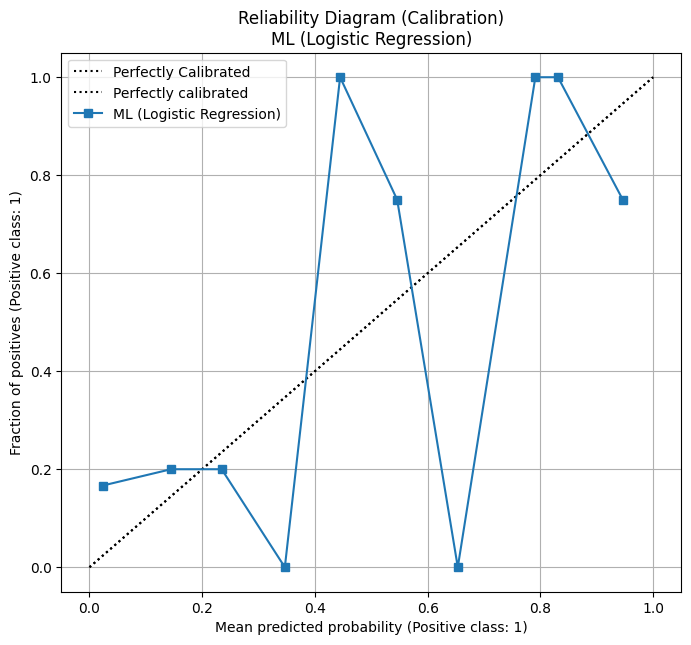


--- ML (Random Forest) ---
Brier Score: 0.1860
Saved plot to: artifacts/figures/FINAL_Calibration_ML_Random_Forest.png


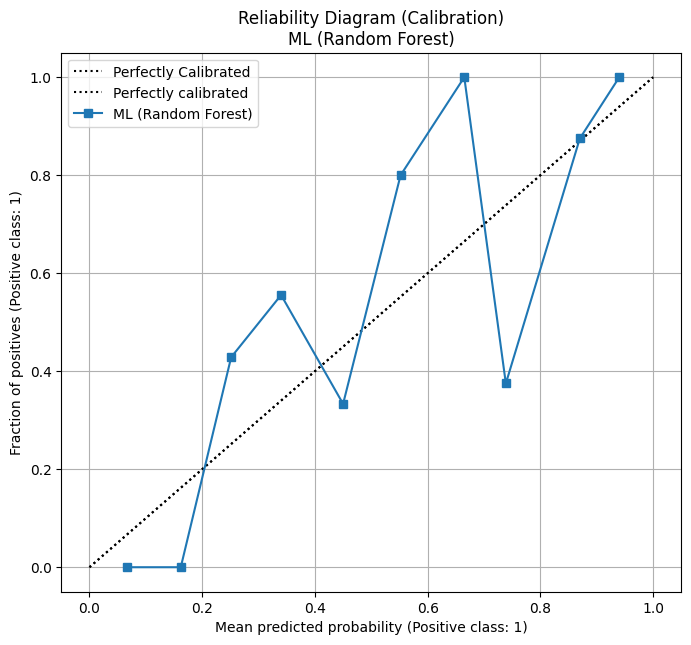


--- ML (KNN) ---
Brier Score: 0.2435
Saved plot to: artifacts/figures/FINAL_Calibration_ML_KNN.png


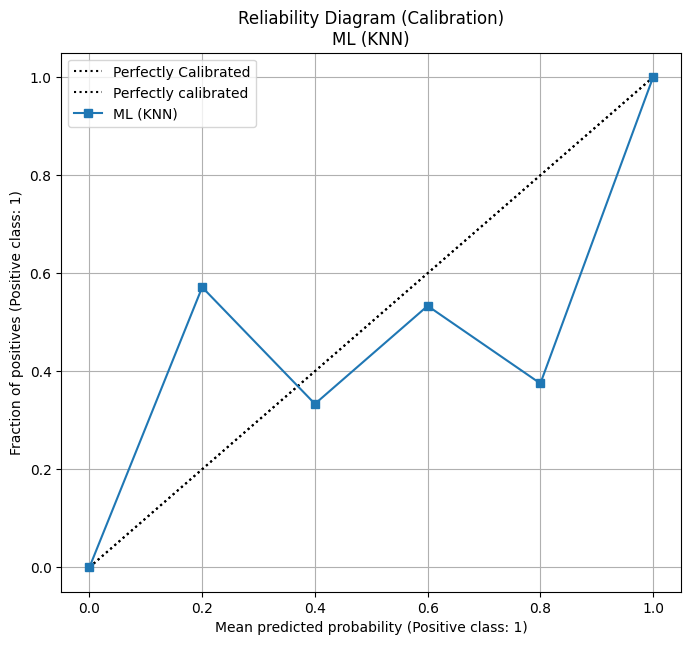


--- DL (EfficientNet-B0) ---
Brier Score: 0.3212
Saved plot to: artifacts/figures/FINAL_Calibration_DL_EfficientNet-B0.png


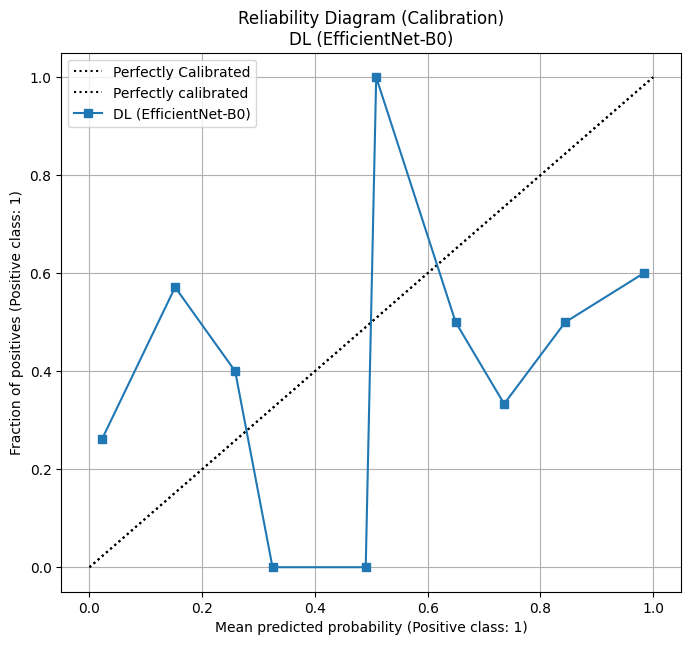


--- FM (MedCLIP+LoRA) ---
Brier Score: 0.2232
Saved plot to: artifacts/figures/FINAL_Calibration_FM_MedCLIPLoRA.png


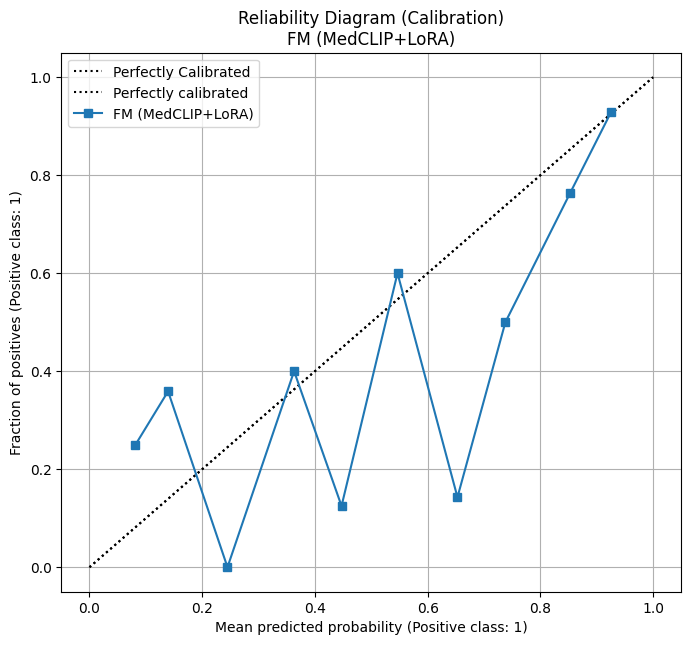


Step 9 Complete.


In [16]:
print("Starting Step 9: Calibration Analysis (5 Individual Plots)...")

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import brier_score_loss

try:
    model_data_to_plot = [
        ("ML (Logistic Regression)", y_true_ml, y_prob_lr),
        ("ML (Random Forest)", y_true_ml, y_prob_rf),
        ("ML (KNN)", y_true_ml, y_prob_knn),
        ("DL (EfficientNet-B0)", y_true, y_prob_cnn),
        ("FM (MedCLIP+LoRA)", y_true, y_prob_medclip)
    ]
except NameError as e:
    print(f"CRITICAL ERROR: A prediction variable is missing. {e}")
    print("Please run all model evaluation steps first.")
    model_data_to_plot = []

for model_name, y_true_data, y_prob_data in model_data_to_plot:

    brier = brier_score_loss(y_true_data, y_prob_data)
    print(f"\n--- {model_name} ---")
    print(f"Brier Score: {brier:.4f}")

    fig, ax = plt.subplots(figsize=(8, 7))

    ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

    CalibrationDisplay.from_predictions(
        y_true_data,
        y_prob_data,
        n_bins=10,
        name=model_name,
        ax=ax,
        strategy='uniform'
    )

    ax.set_title(f"Reliability Diagram (Calibration)\n{model_name}")
    ax.grid(True)
    ax.legend(loc="upper left")

    safe_filename = model_name.replace(' ', '_').replace('(', '').replace(')', '').replace('+', '')
    calibration_path = f"artifacts/figures/FINAL_Calibration_{safe_filename}.png"

    plt.savefig(calibration_path, bbox_inches="tight", dpi=300)
    print(f"Saved plot to: {calibration_path}")
    plt.show()

print("\nStep 9 Complete.")

In [14]:
print("Starting Step 10: Robustness & Fairness Mitigation...")

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pydicom
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    precision_score, recall_score, average_precision_score,
    confusion_matrix
)
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 224
BATCH_SIZE = 32
TARGET_INDEX = 9
print(f"Using device: {DEVICE}")

def parse_label_array(s: str) -> np.ndarray:
    s = str(s).strip().replace('[', '').replace(']', '').replace(',','')
    return np.array([int(x) for x in s.split() if x.strip().isdigit()], dtype=int)

def build_path_dcm(r):
    DICOM_ROOT = "./MIMIC-CXR-png/MIMIC-CXR"
    return f"{DICOM_ROOT}/files/p{str(r.subject_id)[:2]}/p{r.subject_id}/s{r.study_id}/{r.dicom_id}.dcm"

class CXRDicomDataset(Dataset):
    def __init__(self, df, transform, target_index=TARGET_INDEX):
        self.df = df
        self.transform = transform
        self.target_index = target_index
        if 'image_path' not in self.df.columns:
             self.df['image_path'] = self.df.apply(build_path_dcm, axis=1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        image_path = r['image_path']
        try:
            ds = pydicom.dcmread(image_path)
            arr = ds.pixel_array.astype(float)
            if arr.max() > 0:
                arr = (arr - arr.min()) / (arr.max() - arr.min())
            if ds.PhotometricInterpretation == "MONOCHROME1":
                arr = 1.0 - arr
            image = Image.fromarray((arr * 255).astype(np.uint8)).convert("RGB")
        except Exception as e:
            image = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE))
        image = self.transform(image)
        labels_vec = parse_label_array(r['labels_encoded'])
        label = torch.tensor(labels_vec[self.target_index], dtype=torch.float32)
        return image, label

print("\n--- Starting Part 10A: Robustness Test ---")

data_transform_test_robust = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

try:
    test_dataset_robust = CXRDicomDataset(test_df.copy(), data_transform_test_robust)
    test_loader_robust = DataLoader(
        test_dataset_robust,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )
    print("Robustness test loader created.")
except Exception as e:
    print(f"Error creating robustness loader: {e}")

if 'model_cnn' in locals() and 'test_loader_robust' in locals():
    model_cnn.eval()
    all_labels_robust = []
    all_preds_robust = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader_robust, desc="Evaluating Robustness"):
            images = images.to(DEVICE)
            logits = model_cnn(images)
            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds_robust.extend(preds.flatten())
            all_labels_robust.extend(labels.numpy().flatten())

    all_labels_robust = np.array(all_labels_robust)
    all_preds_robust = np.array(all_preds_robust)
    all_preds_binary_robust = (all_preds_robust > 0.5).astype(int)

    auc_robust = roc_auc_score(all_labels_robust, all_preds_robust)
    f1_robust = f1_score(all_labels_robust, all_preds_binary_robust)
    acc_robust = accuracy_score(all_labels_robust, all_preds_binary_robust)

    try:
        original_auc = auc_cnn
        original_f1 = f1_cnn
        original_acc = acc_cnn
    except NameError:
        print("Original metrics (auc_cnn, f1_cnn, acc_cnn) not found. Setting to 0.")
        original_auc, original_f1, original_acc = 0, 0, 0

    print("\n--- CNN (EfficientNet-B0) Robustness Performance (Blurred Images) ---")
    print(f"Metric      | Original | Robust (Blurred) | Drop")
    print(f"-------------------------------------------------------")
    print(f"AUC         | {original_auc:.4f}   | {auc_robust:.4f}         | {original_auc - auc_robust:.4f}")
    print(f"F1-Score    | {original_f1:.4f}   | {f1_robust:.4f}         | {original_f1 - f1_robust:.4f}")
    print(f"Accuracy    | {original_acc:.4f}   | {acc_robust:.4f}         | {original_acc - acc_robust:.4f}")
else:
    print("Skipping robustness test as 'model_cnn' or 'test_loader_robust' is not ready.")

print("\n--- Part 10A Complete ---")


print("\n--- Starting Part 10B: Fairness Mitigation ---")

print("Loading metadata for training...")
try:
    metadata_df = pd.read_csv("/content/metadata_clean.csv")
    train_df_with_meta = train_df.merge(
        metadata_df[['subject_id', 'study_id', 'dicom_id', 'ViewCodeSequence_CodeMeaning']],
        on=['subject_id', 'study_id', 'dicom_id'],
        how='left'
    )
    train_df_with_meta['ViewCodeSequence_CodeMeaning'].fillna('unknown', inplace=True)
    print(f"Total training samples: {len(train_df_with_meta)}")
    print(train_df_with_meta['ViewCodeSequence_CodeMeaning'].value_counts())
except Exception as e:
    print(f"Error loading metadata: {e}. Aborting mitigation.")
    train_df_with_meta = None

if train_df_with_meta is not None:
    class CXRDicomDatasetWithMeta(Dataset):
        def __init__(self, df, transform, target_index=TARGET_INDEX):
            self.df = df
            self.transform = transform
            self.target_index = target_index
            if 'image_path' not in self.df.columns:
                self.df['image_path'] = self.df.apply(build_path_dcm, axis=1)

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            r = self.df.iloc[idx]
            image_path = r['image_path']
            try:
                ds = pydicom.dcmread(image_path)
                arr = ds.pixel_array.astype(float)
                if arr.max() > 0:
                    arr = (arr - arr.min()) / (arr.max() - arr.min())
                if ds.PhotometricInterpretation == "MONOCHROME1":
                    arr = 1.0 - arr
                image = Image.fromarray((arr * 255).astype(np.uint8)).convert("RGB")
            except Exception as e:
                image = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE))

            image = self.transform(image)
            labels_vec = parse_label_array(r['labels_encoded'])
            label = torch.tensor(labels_vec[self.target_index], dtype=torch.float32)

            is_pa_view = 1.0 if r['ViewCodeSequence_CodeMeaning'] == 'postero-anterior' else 0.0
            is_pa_view = torch.tensor(is_pa_view, dtype=torch.float32)

            return image, label, is_pa_view

    print("Creating new DataLoaders with metadata...")
    data_transform_train = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset_mitigated = CXRDicomDatasetWithMeta(train_df_with_meta, data_transform_train)
    train_loader_mitigated = DataLoader(
        train_dataset_mitigated,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )
    print("Mitigation train loader created.")

    print("Creating NEW EfficientNet-B0 model for mitigation...")
    model_cnn_mitigated = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
    model_cnn_mitigated.to(DEVICE)

    optimizer_mitigated = optim.Adam(model_cnn_mitigated.parameters(), lr=1e-4)
    criterion_mitigated = nn.BCEWithLogitsLoss(reduction='none')

    NUM_EPOCHS_CNN = 5
    MITIGATION_WEIGHT = 3.0
    print(f"Using mitigation weight: {MITIGATION_WEIGHT}")

    print(f"Starting CNN training for {NUM_EPOCHS_CNN} epochs...")
    for epoch in range(NUM_EPOCHS_CNN):
        model_cnn_mitigated.train()
        train_loss = 0.0

        for images, labels, is_pa_view in tqdm(train_loader_mitigated, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_CNN}"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).unsqueeze(1)
            is_pa_view = is_pa_view.to(DEVICE).unsqueeze(1)

            optimizer_mitigated.zero_grad()
            logits = model_cnn_mitigated(images)
            loss_per_sample = criterion_mitigated(logits, labels)

            sample_weights = torch.ones_like(labels).to(DEVICE)
            target_group_mask = (is_pa_view == 1.0) & (labels == 1.0)
            sample_weights[target_group_mask] = MITIGATION_WEIGHT
            loss = (loss_per_sample * sample_weights).mean()

            loss.backward()
            optimizer_mitigated.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1} CNN Train Loss: {train_loss / len(train_loader_mitigated):.4f}")

    print("Mitigated CNN Training complete.")

    print("\n--- Re-running Fairness Analysis on MITIGATED Model ---")

    data_transform_test = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    test_dataset = CXRDicomDataset(test_df.copy(), data_transform_test)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    model_cnn_mitigated.eval()
    all_labels_mit = []
    all_preds_probs_mit = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating Mitigated Model"):
            images = images.to(DEVICE)
            outputs = model_cnn_mitigated(images)
            probs = torch.sigmoid(outputs).squeeze()
            all_labels_mit.extend(labels.cpu().numpy())
            all_preds_probs_mit.extend(probs.cpu().numpy())

    all_preds_mit = (np.array(all_preds_probs_mit) >= 0.5).astype(int)
    all_labels_mit = np.array(all_labels_mit).astype(int)

    test_df_with_preds_mit = test_df.copy()
    if len(test_df_with_preds_mit) != len(all_labels_mit):
        test_df_with_preds_mit = test_df_with_preds_mit.iloc[:len(all_labels_mit)]

    test_df_with_preds_mit['true_label'] = all_labels_mit
    test_df_with_preds_mit['prediction'] = all_preds_mit

    merged_for_fairness_mit = test_df_with_preds_mit.merge(
        metadata_df[['subject_id', 'study_id', 'dicom_id', 'ViewCodeSequence_CodeMeaning']],
        on=['subject_id', 'study_id', 'dicom_id'],
        how='left'
    )
    merged_for_fairness_mit.dropna(subset=['ViewCodeSequence_CodeMeaning'], inplace=True)

    if merged_for_fairness_mit.empty:
        print("ERROR: No matching data found after merging with metadata.")
    else:
        print("Calculating mitigated fairness metrics...")
        y_true_mit = merged_for_fairness_mit['true_label']
        y_pred_mit = merged_for_fairness_mit['prediction']
        sensitive_features_mit = merged_for_fairness_mit['ViewCodeSequence_CodeMeaning']

        fairness_metrics = {
            'accuracy': accuracy_score,
            'precision': precision_score,
            'recall (sensitivity)': recall_score,
            'false_positive_rate': false_positive_rate,
            'false_negative_rate': false_negative_rate
        }

        metric_frame_mitigated = MetricFrame(
            metrics=fairness_metrics,
            y_true=y_true_mit,
            y_pred=y_pred_mit,
            sensitive_features=sensitive_features_mit
        )

        print("\n--- Fairness Analysis Results (MITIGATED Model) ---")
        print(metric_frame_mitigated.by_group)
        print("\n--- Fairness Disparities (Difference) [MITIGATED] ---")
        print(metric_frame_mitigated.difference(method='between_groups'))

        try:
            print("\n--- GAP COMPARISON (Sensitivity) ---")
            original_gap = metric_frame.difference(method='between_groups')['recall (sensitivity)']
            mitigated_gap = metric_frame_mitigated.difference(method='between_groups')['recall (sensitivity)']
            print(f"Original Sensitivity Gap: {original_gap:.4f}")
            print(f"Mitigated Sensitivity Gap: {mitigated_gap:.4f}")
            print(f"Improvement (reduction in gap): {original_gap - mitigated_gap:.4f}")
        except NameError:
            print("\n(Run original Step 5 to see 'metric_frame' for comparison)")
        except Exception as e:
            print(f"Could not compare gaps: {e}")

else:
    print("Skipping Part 10B (Fairness Mitigation) due to metadata loading error.")

print("\nStep 10 Complete.")

Starting Step 9: Robustness & Fairness Mitigation...
Using device: cuda

--- Starting Part 9A: Robustness Test ---
Robustness test loader created.


Evaluating Robustness: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]



--- CNN (EfficientNet-B0) Robustness Performance (Blurred Images) ---
Metric      | Original | Robust (Blurred) | Drop
-------------------------------------------------------
AUC         | 0.7105   | 0.5626         | 0.1479
F1-Score    | 0.6218   | 0.1967         | 0.4251
Accuracy    | 0.6311   | 0.5984         | 0.0328

--- Part 9A Complete ---

--- Starting Part 9B: Fairness Mitigation ---
Loading metadata for training...
Total training samples: 549
ViewCodeSequence_CodeMeaning
antero-posterior    327
postero-anterior    220
unknown               2
Name: count, dtype: int64
Creating new DataLoaders with metadata...
Mitigation train loader created.
Creating NEW EfficientNet-B0 model for mitigation...
Using mitigation weight: 3.0
Starting CNN training for 5 epochs...


Epoch 1/5: 100%|██████████| 18/18 [00:39<00:00,  2.22s/it]


Epoch 1 CNN Train Loss: 2.1873


Epoch 2/5: 100%|██████████| 18/18 [00:40<00:00,  2.27s/it]


Epoch 2 CNN Train Loss: 1.3643


Epoch 3/5: 100%|██████████| 18/18 [00:39<00:00,  2.21s/it]


Epoch 3 CNN Train Loss: 0.8736


Epoch 4/5: 100%|██████████| 18/18 [00:40<00:00,  2.24s/it]


Epoch 4 CNN Train Loss: 0.7665


Epoch 5/5: 100%|██████████| 18/18 [00:39<00:00,  2.22s/it]


Epoch 5 CNN Train Loss: 0.5154
Mitigated CNN Training complete.

--- Re-running Fairness Analysis on MITIGATED Model ---


Evaluating Mitigated Model: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

Calculating mitigated fairness metrics...

--- Fairness Analysis Results (MITIGATED Model) ---
                              accuracy  precision  recall (sensitivity)  \
ViewCodeSequence_CodeMeaning                                              
antero-posterior              0.593023   0.486486              0.529412   
postero-anterior              0.777778   0.750000              0.900000   

                              false_positive_rate  false_negative_rate  
ViewCodeSequence_CodeMeaning                                            
antero-posterior                         0.365385             0.470588  
postero-anterior                         0.375000             0.100000  

--- Fairness Disparities (Difference) [MITIGATED] ---
accuracy                0.184755
precision               0.263514
recall (sensitivity)    0.370588
false_positive_rate     0.009615
false_negative_rate     0.370588
dtype: float64

--- GAP COMPARISON (Sensitivity) ---
Original Sensitivity Gap: 0.1824
Mitiga